In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from models import BFDataset, VAE, BFVAE
from MMD_func import MMD_U as MMD
rng = np.random.default_rng()

In [23]:
# import training and test data
path = 'Data/burgers-data.npz'
file = np.load(path)
idx = np.linspace(126,253,128).astype('int')
idx = np.linspace(0,253,254).astype('int')
LF, HF = file['burgers_yL'], file['burgers_yH']

xL_trn = torch.from_numpy(LF[:400, idx]).type(torch.FloatTensor)
xL = torch.from_numpy(LF[:8000, idx]).type(torch.FloatTensor)
xH = torch.from_numpy(HF[:8000, idx]).type(torch.FloatTensor)
xH_tst = torch.from_numpy(HF[8000: 9000, idx]).type(torch.FloatTensor)

In [24]:
## Universal hyper-para
_,input_dim = xH_tst.shape
batch_size = 64
tst_size = 1000
mmd_para = [0.2, 0.5, 1.0, 2.0, 5.0]
latent_dim = 4
hidden_dims = [256, 128, 64, 16]
beta = 1e-4
num_trial = 10
hf_size_lst = [2, 3, 4, 5, 7, 8, 10, 50, 100, 500, 1000]


# claim and train lf-vae
lfvae_model = VAE(input_dim, latent_dim, hidden_dims, beta)
lfvae_loss = lfvae_model.train(xL_trn, epochs=2000)

100%|██████████| 2000/2000 [02:26<00:00, 13.66 Epoch/s, loss=0.12218039] 


In [ ]:
hf_mmd_lst, bf_mmd_lst = [], []
hfvae_lst, bfvae_lst = [], []
for hf_size in hf_size_lst:
    hf_mmd, bf_mmd = [], []
    hfvae, bfvae = [], []
    for _ in range(num_trial):      
        # claim and train hf-vae
        hf_trn_idx = rng.choice(8000, hf_size, replace=False)
        hf_trn_data = xH[hf_trn_idx]
        hfvae_model = VAE(input_dim, latent_dim, hidden_dims, beta)
        hfvae.append(hfvae_model)
        hfvae_loss = hfvae_model.train(hf_trn_data, epochs=1000)

        # claim and train bf-vae
        hf_trn_data = xH[hf_trn_idx]
        lf_trn_data = xL[hf_trn_idx]
        bf_trn_data = BFDataset(lf_trn_data, hf_trn_data)
        bfvae_model = BFVAE(lfvae_model)
        bfvae.append(bfvae_model)
        bfvae_loss = bfvae_model.train(bf_trn_data, epochs=1000)

        ## Compute MMD result
        # HF-VAE
        hf_gen = hfvae_model.sample(1000)
        hf_mmd.append(MMD(hf_gen, xH_tst, mmd_para)) 

        # BF-VAE
        bf_gen = bfvae_model.sample(1000)
        bf_mmd.append(MMD(bf_gen, xH_tst, mmd_para)) 
        
    hf_mmd_lst.append(hf_mmd)
    bf_mmd_lst.append(bf_mmd)
    hfvae_lst.append(hfvae)
    bfvae_lst.append(bfvae)

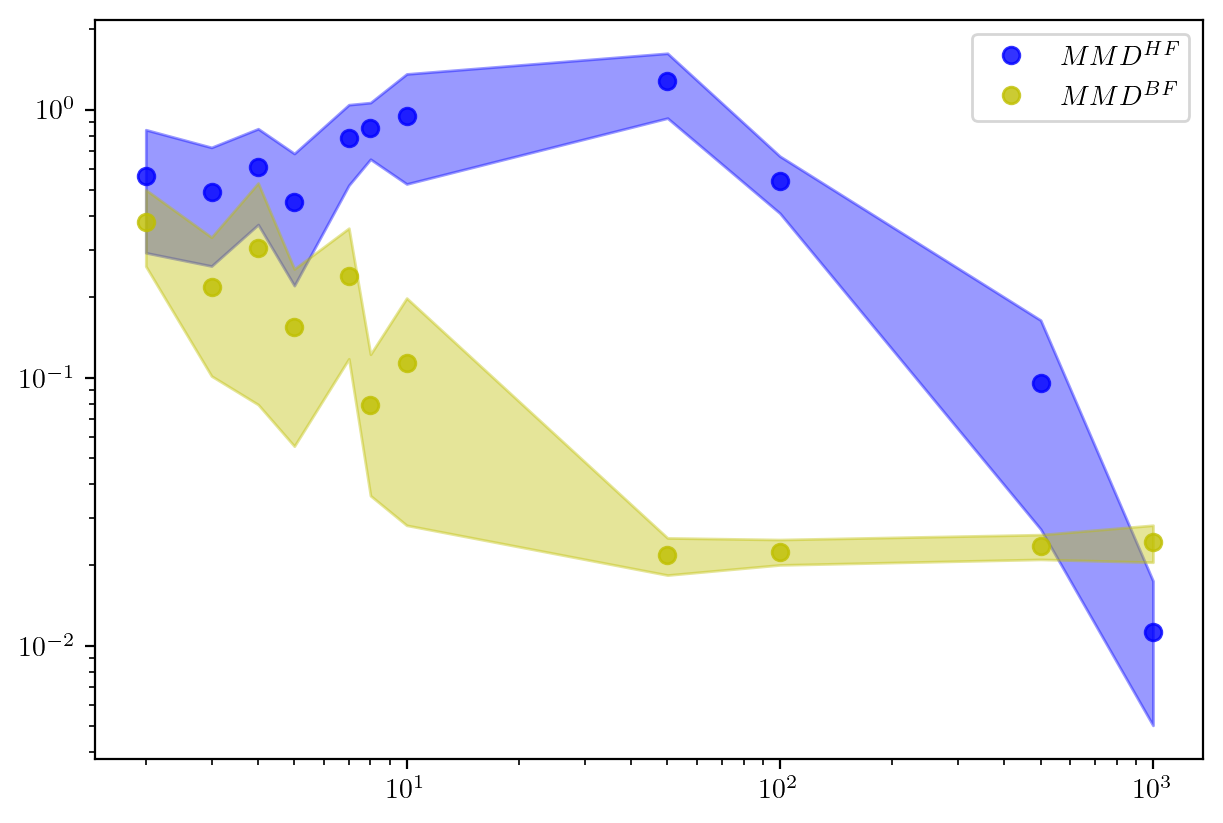

In [26]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.constrained_layout.use'] = True

scale = 0.5
hf_mean, bf_mean = np.mean(hf_mmd_lst, axis=1), np.mean(bf_mmd_lst, axis=1)
hf_std, bf_std = np.std(hf_mmd_lst, axis=1), np.std(bf_mmd_lst, axis=1)
plt.plot(hf_size_lst, hf_mean, 'o' ,c='b', label=r'$MMD^{HF}$', alpha=0.8)
plt.fill_between(hf_size_lst, hf_mean - scale * hf_std, hf_mean + scale * hf_std, color='b', alpha=0.4)
plt.plot(hf_size_lst, bf_mean, 'o' ,c='y', label=r'$MMD^{BF}$', alpha=0.8)
plt.fill_between(hf_size_lst, bf_mean - scale * bf_std, bf_mean + scale * bf_std, color='y', alpha=0.4)
plt.legend()
plt.xscale('log')
plt.yscale('log')

[  10   50 1000]


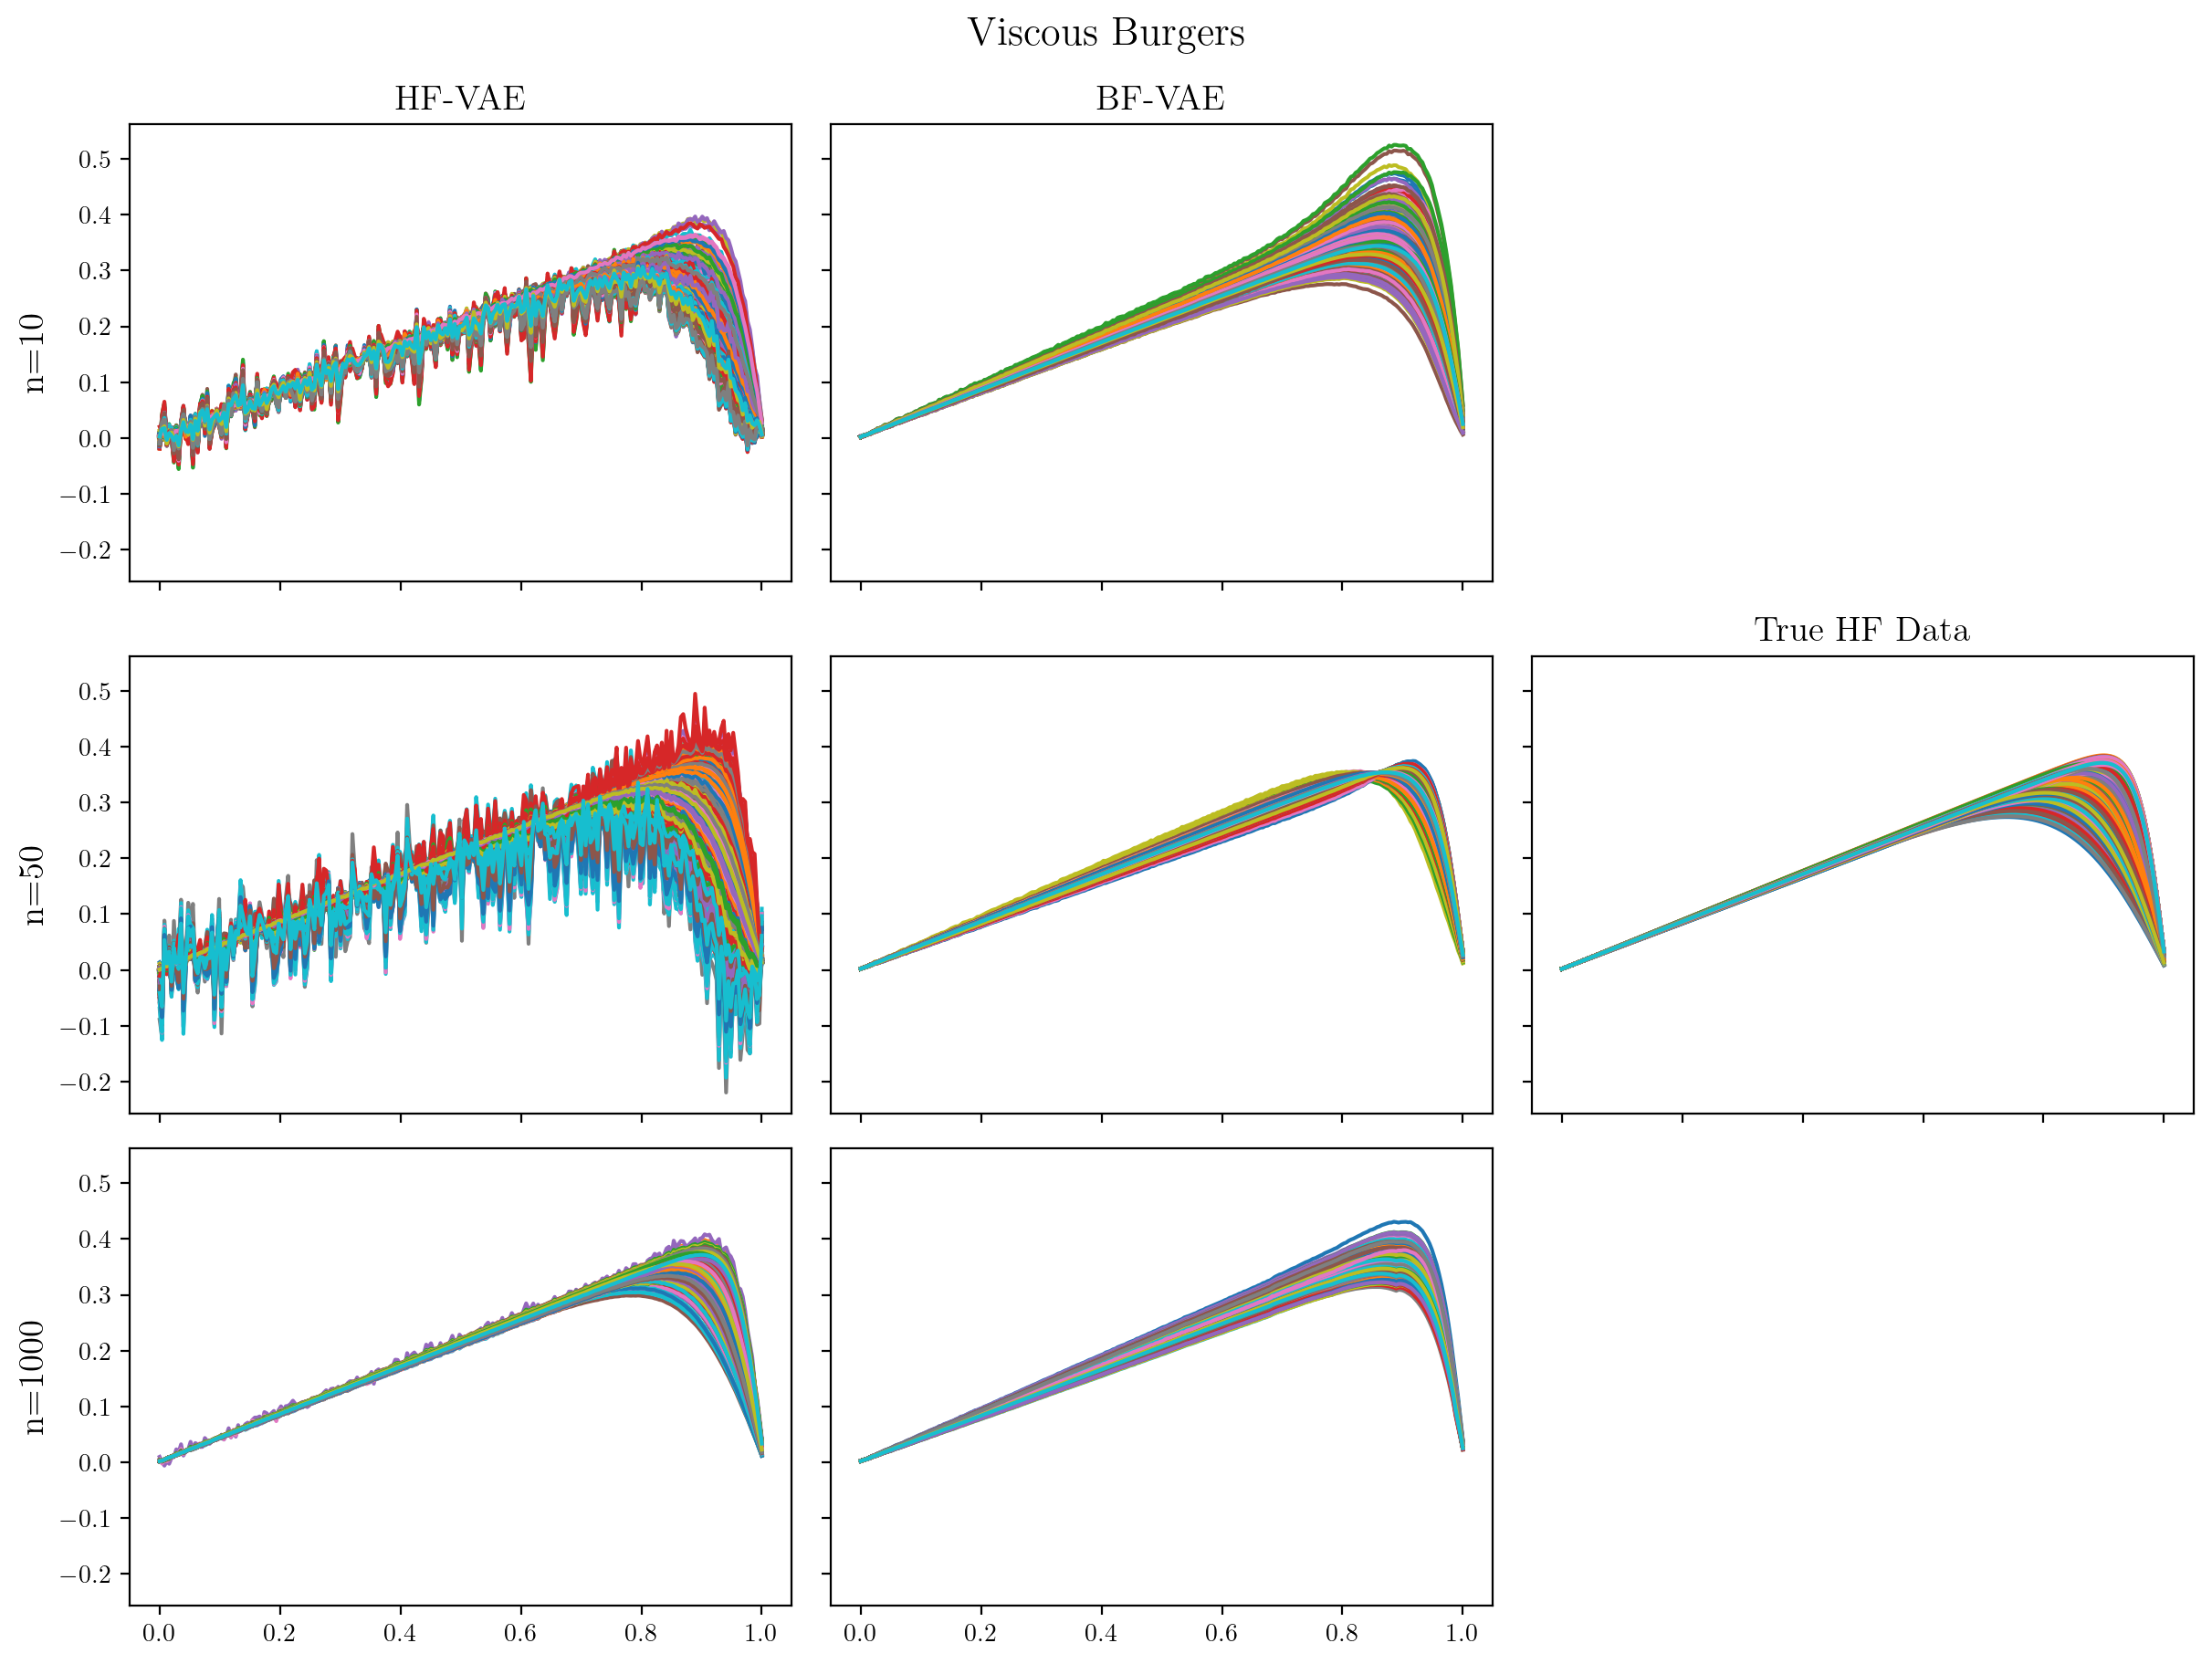

In [27]:

fig, axs = plt.subplots(3,3,figsize=(12,9),sharey=True,sharex=True)
fig.suptitle('Viscous Burgers', fontsize=16)
t = np.linspace(0,1.0,input_dim)
hf_N = [6, 7, 10]
print(np.array(hf_size_lst)[hf_N])

bf_gen_lst, hf_gen_lst = [], []

for i in range(1000):
    axs[1,2].plot(t, xH_tst[i].detach().numpy())

axs[0,2].axis('off')
axs[2,2].axis('off')
axs[0,0].set_title(r'HF-VAE',fontsize=14)
axs[0,1].set_title(r'BF-VAE',fontsize=14)
axs[1,2].set_title(r'True HF Data',fontsize=14)

for j in range(len(hf_N)):
    N = hf_N[j]
    axs[j,0].set_ylabel(r'n='+str(hf_size_lst[N]),fontsize=14)
    bf_gen = bfvae_lst[N][0].sample(1000).detach().numpy()
    hf_gen = hfvae_lst[N][0].sample(1000).detach().numpy()
    bf_gen_lst.append(bf_gen)
    hf_gen_lst.append(hf_gen)
    for i in range(1000):
        axs[j,0].plot(t, hf_gen[i])
        axs[j,1].plot(t, bf_gen[i])

<ipython-input-31-5784bcd83245>:48: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.savefig('burgers-comparison.pdf', format='pdf')
/Users/nokicheng/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


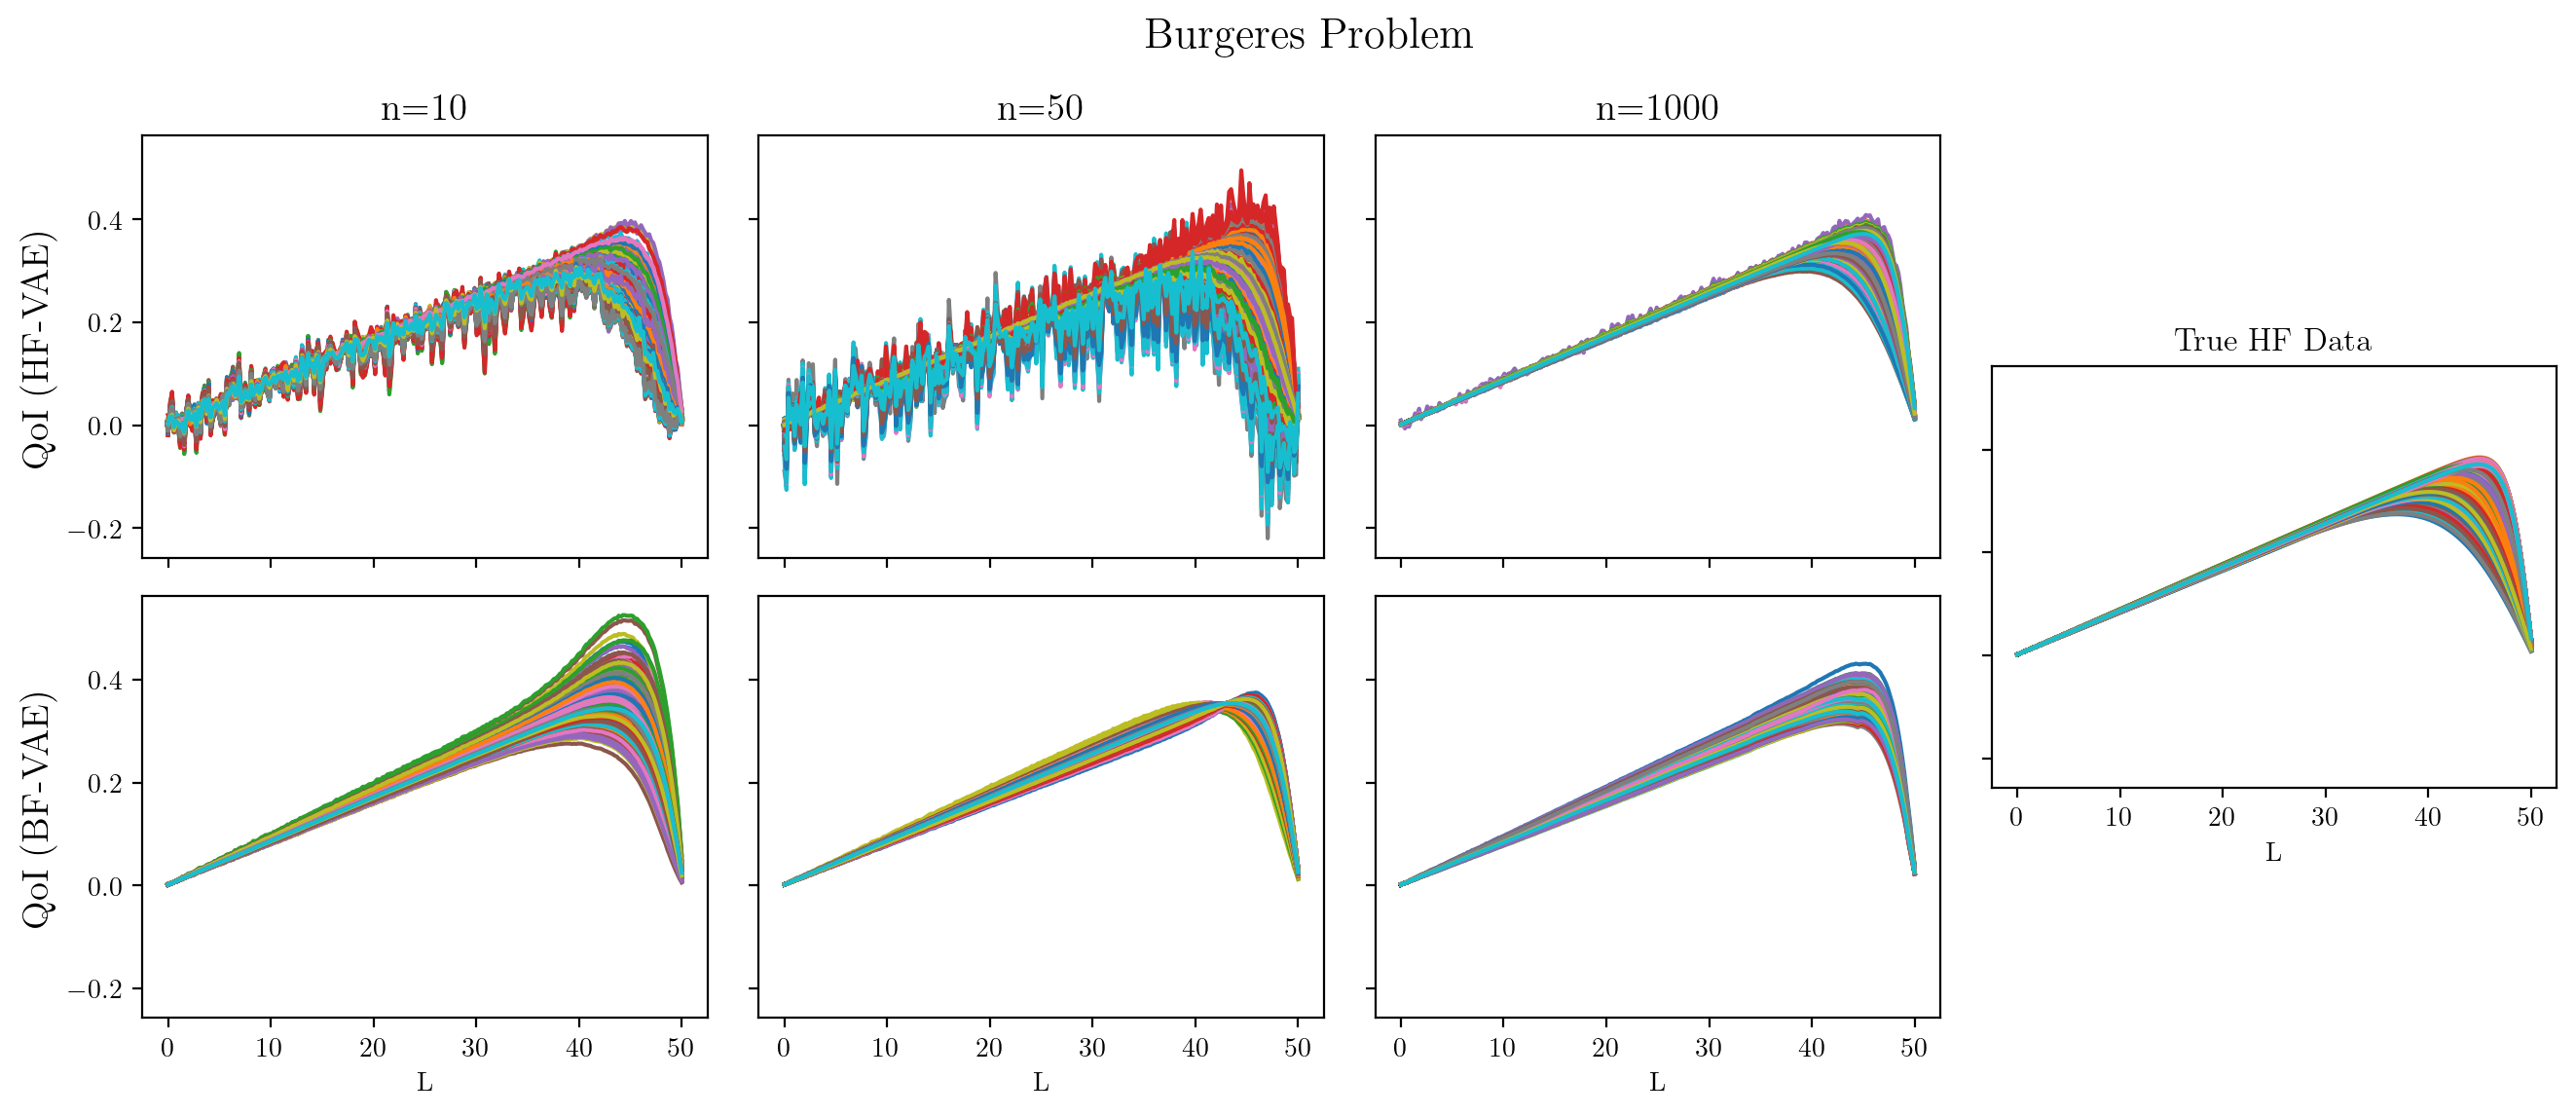

In [31]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

hf_gen_lst = np.array(hf_gen_lst)
bf_gen_lst = np.array(bf_gen_lst)

#plt.rcParams['figure.constrained_layout.use'] = True
fig = plt.figure(figsize=(16,6))
fig.suptitle('Burgeres Problem', fontsize=16)
t = np.linspace(0,50,254)

ax1 = plt.subplot2grid((4, 8), (0, 0), rowspan=2, colspan=2)
ax2 = plt.subplot2grid((4, 8), (2, 0), rowspan=2, colspan=2,sharex=ax1,sharey=ax1)
ax3 = plt.subplot2grid((4, 8), (0, 2), rowspan=2, colspan=2,sharex=ax1,sharey=ax1)
ax4 = plt.subplot2grid((4, 8), (2, 2), rowspan=2, colspan=2,sharex=ax1,sharey=ax1)
ax5 = plt.subplot2grid((4, 8), (0, 4), rowspan=2, colspan=2,sharex=ax1,sharey=ax1)
ax6 = plt.subplot2grid((4, 8), (2, 4), rowspan=2, colspan=2,sharex=ax1,sharey=ax1)
ax7 = plt.subplot2grid((4, 8), (1, 6), rowspan=2, colspan=2,sharex=ax1,sharey=ax1)

axs = [[ax1,ax3,ax5],[ax2,ax4,ax6]]

for ax in [ax1,ax3,ax5]:
    ax.tick_params(labelbottom=False)
for ax in [ax3,ax4,ax5,ax6,ax7]:
    ax.tick_params(labelleft=False)

axs[0][0].set_ylabel(r'QoI (HF-VAE)',fontsize=14)
axs[1][0].set_ylabel(r'QoI (BF-VAE)',fontsize=14)

for j in range(len(hf_N)):
    N = hf_N[j]
    axs[0][j].set_title(r'n='+str(hf_size_lst[N]),fontsize=14)
    for i in range(1000):
        axs[0][j].plot(t, hf_gen_lst[j, i])
        axs[1][j].plot(t, bf_gen_lst[j, i])

for i in range(1000):
    ax7.plot(t, xH_tst[i].detach().numpy())
ax7.set_title('True HF Data')

ax2.set_xlabel(r'L')
ax4.set_xlabel(r'L')
ax6.set_xlabel(r'L')
ax7.set_xlabel(r'L')

In [29]:
mmd_list = np.array([hf_mmd_lst, bf_mmd_lst])
hf_size_list = hf_size_lst

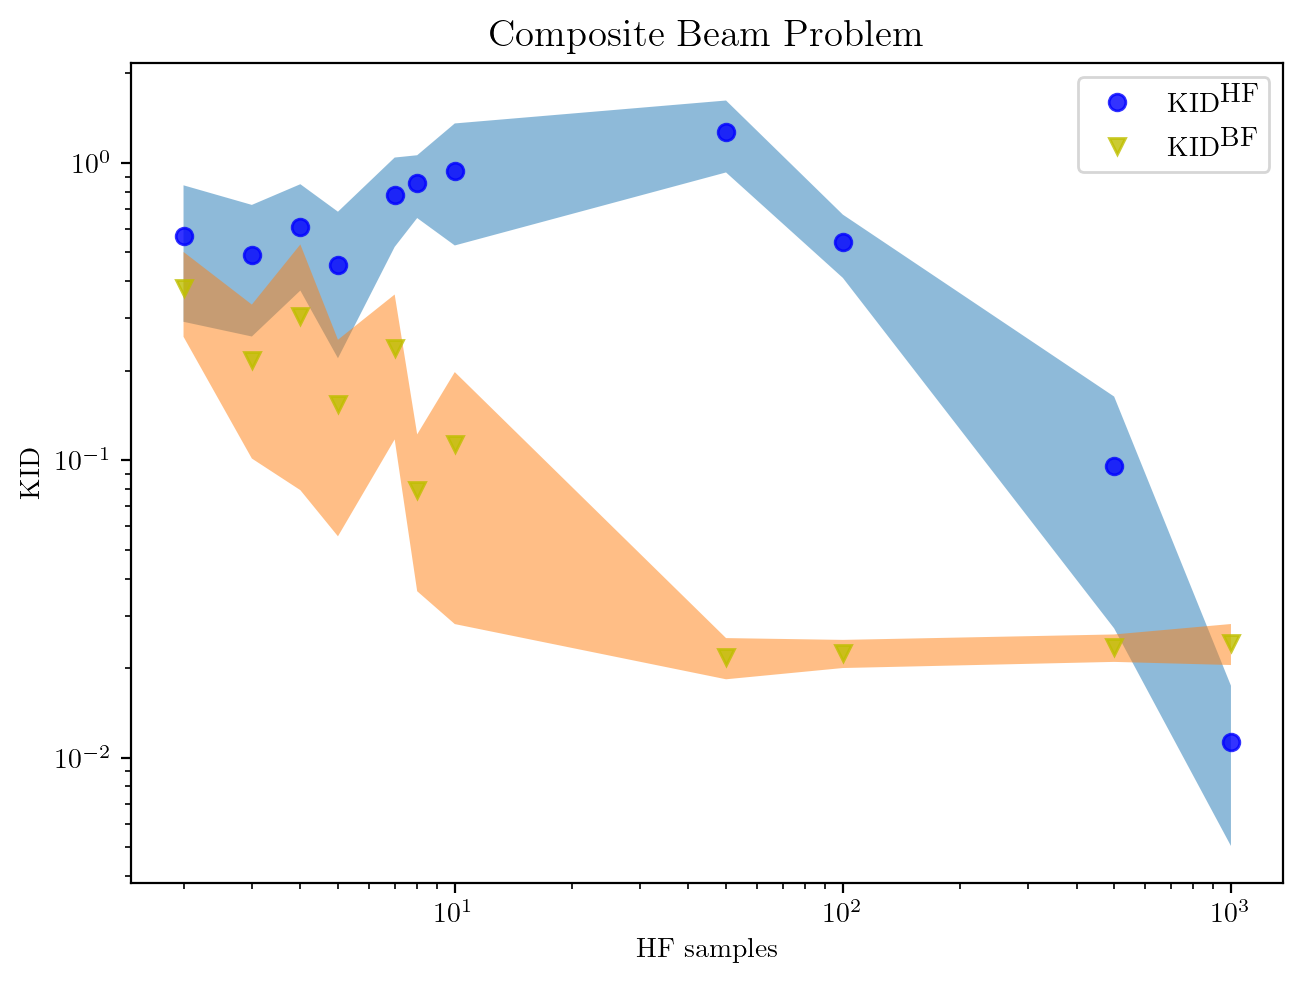

In [32]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
# Draw a figure of MMD performance for BF-VAE and HF-VAE
mean_value_list = np.mean(np.abs(mmd_list),axis=2)
std = np.std(np.abs(mmd_list),axis=2)
fig = plt.figure(figsize=(6.4, 4.8))
plt.plot(hf_size_list,mean_value_list[0],'o',c='b',label=r'KID$^\textup{HF}$',alpha=0.8)
plt.plot(hf_size_list,mean_value_list[1],'v',c='y',label=r'KID$^\textup{BF}$',alpha=0.8)
width = 0.5
plt.fill_between(hf_size_list,mean_value_list[0]+width*std[0],mean_value_list[0]-width*std[0],alpha=0.5)
plt.fill_between(hf_size_list,mean_value_list[1]+width*std[1],mean_value_list[1]-width*std[1],alpha=0.5)
plt.title('Composite Beam Problem',fontsize=14)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('HF samples')
plt.ylabel(r'KID')